# Homework 1: Six Degrees of Kevin Bacon

Read [bfs_six_degrees.pdf](bfs_six_degrees.pdf) for the assignment spec. Submit this .ipynb to the professor to demonstrate your solution. This is unofficial and is maintained by a fellow student, Justin, aka the glizzy goblin.

In [5]:
from graph_tools import graph
from collections import deque
from random import sample
from timeit import timeit
import matplotlib.pyplot as plt

In [6]:
# Helper Functions
def process_credits_file_to_graph(graph:graph, file_path:str):
    try:
        with  open(file_path, 'r', encoding='utf-8') as list_edges:
            for line in list_edges:
                process_line(graph, line)
    except FileNotFoundError:
        print(f"Error: was not able to find {file_path}")
    except UnicodeDecodeError as e:
        print(f"Encoding error while reading the file: {e}")

def process_line(graph:graph, line:str):
    split_line = line.strip().split()
    if not split_line: return
    
    movie_name, actors = split_line[0], split_line[1:]
    
    for actor_1 in actors:
        co_stars = [actor for actor in actors if actor != actor_1]
        for actor_2 in co_stars:
            graph.Add_und_edge(actor_1, actor_2, movie_name)

In [7]:
small_actor_graph = graph()
small_file_path = "smaller_imdb_cleaned.txt"
process_credits_file_to_graph(small_actor_graph, small_file_path)

In [8]:
large_actor_graph = graph()
large_actor_file = "all_imdb_cleaned.txt"
process_credits_file_to_graph(large_actor_graph, large_actor_file)

In [9]:
def format_output(merged_result:list):
    if not merged_result: return "No path found"
    out=""
    for i in range(len(merged_result)):
        if i % 2 == 1:
            out += f"-({merged_result[i]})-"
            continue
        out += merged_result[i]
    return out

**Vanilla BFS**

In [12]:
def reconstruct_path(adj, current, graph, merged: bool):
        # reconstruct path from start to end given adjacency list        
        total_path = []
        while current in adj and current != None:
            total_path.append(current)
            current = adj[current]
        total_path = total_path[::-1]
        movies = [graph.adj_list[total_path[i]][total_path[i + 1]] for i in range(len(total_path) - 1)]
        
        # merge results between actor names and movie edges
        if merged:
            merged_result = [item for pair in zip(total_path, movies) for item in pair]
            merged_result.extend(total_path[len(movies):])
            return merged_result
        
        return total_path, movies

def bfs(start:str, end:str, graph:graph, merged:bool):
    """
    Perform BFS and return results based on the mode:
    - "shortest_path": Return the shortest path from start to end.
    - "level_set": Return the level sets (vertices grouped by distance).
    - "connectivity": Return True/False if end is reachable from start.
    - "edge_count": Return the total number of edges traversed.
    """
    if start not in graph.vertices:
        return "Not Present" 
    if end != None and end not in graph.vertices:
        return "Not Present"  

    queue = deque([start])
    visited = {actor: False for actor in graph.vertices}
    pred = {actor: None for actor in graph.vertices}
    # level_set = {0:[start]}
    # distances = {start: 0}
    count = 0
    
    visited[start] = True
    
    # while queue is not empty
    while queue:
        # pop from queue
        current = queue.popleft()
        # current_level = distances[current]

        if(current == end and end != None):
            return reconstruct_path(adj=pred, current=current, graph=graph, merged=merged)

        for neighbor in graph.adj_list[current]:    
            if not visited[neighbor]:
                visited[neighbor] = True
                pred[neighbor] = current
                # distances[neighbor] = current_level + 1
                count += 1
                queue.append(neighbor)
               
                
    return "Not present" if end != None else count
     

**Bi-Directional BFS**

In [13]:
# Refrenced https://www.geeksforgeeks.org/bidirectional-search/

def reconstruct_bidi_path(start_pred:dict, end_pred:dict, start:str,end:str, mid:str, graph:graph, merged: bool):
    
	total_path = []
	current = mid
	while current in start_pred and current != None:
		total_path.append(current)
		current = start_pred[current]
  
	total_path = total_path[::-1]
	current = end_pred[mid]
 
	while current in end_pred and current != None:
		total_path.append(current)
		current = end_pred[current]
	
	movies = [graph.adj_list[total_path[i]][total_path[i + 1]] for i in range(len(total_path) - 1)]
	if merged :
		# merge results between actor names and movie edges
		merged_result = [item for pair in zip(total_path, movies) for item in pair]
		merged_result.extend(total_path[len(movies):])
		return merged_result
	return total_path, movies

def BiDi_BFS(start: str, end: str, graph: graph, merged:bool):
	if start not in graph.vertices or end not in graph.vertices:
		return "Not present"
	start_queue = deque([])
	end_queue = deque([])

	# initializes start and end visted nodes as false
	start_visited = {actor: False for actor in graph.vertices}
	end_visited = {actor: False for actor in graph.vertices}

	#initialize start and end adj list
	start_pred = {actor: None for actor in graph.vertices}
	end_pred = {actor: None for actor in graph.vertices}
	
	start_queue.append(start)
	start_visited[start] = True
 
	end_queue.append(end)
	end_visited[end] = True
	
	while len(start_queue) > 0  and len(end_queue) > 0:
		# Forward BFS
		curr_start = start_queue.popleft()
		for neighbor in graph.adj_list[curr_start]:
			if not start_visited[neighbor]:
				start_visited[neighbor] = True
				start_pred[neighbor] = curr_start
				start_queue.append(neighbor)
			if(end_visited[neighbor]): # intersection has been found
				return reconstruct_bidi_path(start_pred, end_pred, start, end, neighbor, graph, merged)
			
		# Backward BFS
		curr_end = end_queue.popleft()
		for neighbor in graph.adj_list[curr_end]:
			if not end_visited[neighbor]:
				end_visited[neighbor] = True
				end_pred[neighbor] = curr_end
				end_queue.append(neighbor)
			if(start_visited[neighbor]): # intersection has been found
				return reconstruct_bidi_path(start_pred, end_pred, start, end, neighbor, graph, merged)
	
	return "No Path Found"

## What You Need to Find

This section outlines the specific questions you need to answer. Ensure each question is addressed in a separate code block, with the output clearly presented as either text or visual plots.



1. **Shortest Paths**: For each credits file, find the shortest paths for all the pairs provided in the example input files. Handle corner cases such as:
   - An actor not being present in the graph.
   - The source and destination actors not being connected.  
   Output appropriate messages for these cases.



In [ ]:
input_file = "more-input.txt"
output_file = "more-output.txt"

input_parameters = open(input_file, 'r', encoding='utf-8')
expected_output = open(output_file, 'r', encoding='utf-8')

print("Small Credit Graph\n")
for param, out in zip(input_parameters, expected_output):
    striped_param = param.strip().split()
    start, end = striped_param[0], striped_param[1]
    path = BiDi_BFS(start=start, end=end, graph=small_actor_graph, merged=False)
    if type(path)== str : print(f"{path}\n")
    else: print(f"{format_output(path)}\n")

input_parameters.close()
expected_output.close()

In [ ]:
input_file = "more-input.txt"
output_file = "more-output.txt"

input_parameters = open(input_file, 'r', encoding='utf-8')
expected_output = open(output_file, 'r', encoding='utf-8')

print("Large Credit Graph\n")
for param, out in zip(input_parameters, expected_output):
    striped_param = param.strip().split()
    start, end = striped_param[0], striped_param[1]
    path = BiDi_BFS(start=start, end=end, graph=large_actor_graph, merged=False)
    if type(path)== str : print(f"{path}\n")
    else: print(f"{format_output(path)}\n")

input_parameters.close()
expected_output.close()

2. **Interesting Paths**: Identify and include some interesting shortest paths discovered in either credits file.


In [ ]:
NUM_OF_ACTORS = 20
sub_set_actors = sample(list(small_actor_graph.vertices), NUM_OF_ACTORS)

mid_index = len(sub_set_actors) // 2  
sub_set_actors_1 = sub_set_actors[:mid_index]
sub_set_actors_2 = sub_set_actors[mid_index:]


for actor_1, actor_2 in zip(sub_set_actors_1, sub_set_actors_2):
    print(f"{actor_1} {actor_2}")
    path = bfs(start=actor_1, end=actor_2, graph=small_actor_graph, merged=False)
    if type(path)== str : print(f"Small actor graph output: {path}\n")
    else: print(f"Small actor graph output:{format_output(path)}\n")

for actor_1, actor_2 in zip(sub_set_actors_1, sub_set_actors_2):
    print(f"{actor_1} {actor_2}")
    path = bfs(start=actor_1, end=actor_2, graph=large_actor_graph, merged=False)
    if type(path)== str : print(f"Large actor graph output: {path}\n")
    else: print(f"Large actor graph output:{format_output(path)}\n\n")
        

In [ ]:
import matplotlib.pyplot as plt
from collections import deque

# Function to compute shortest paths from a given start vertex
def compute_shortest_paths(graph, start):
    visited = {v: False for v in graph.vertices}
    distance = {v: float('inf') for v in graph.vertices}
    count_paths = {v: 0 for v in graph.vertices}  # Number of shortest paths to each vertex

    queue = deque([start])
    visited[start] = True
    distance[start] = 0
    count_paths[start] = 1

    while queue:
        current = queue.popleft()
        for neighbor in graph.adj_list[current]:
            # If visiting a node for the first time
            if not visited[neighbor]:
                visited[neighbor] = True
                distance[neighbor] = distance[current] + 1
                queue.append(neighbor)
            # If another shortest path to the neighbor is found
            if distance[neighbor] == distance[current] + 1:
                count_paths[neighbor] += count_paths[current]

    return count_paths

# Function to compute the total number of shortest paths for a graph
def total_shortest_paths(graph):
    total_paths = 0
    for vertex in graph.vertices:
        paths = compute_shortest_paths(graph, vertex)
        total_paths += sum(paths.values())  # Add all shortest paths from this vertex
    return total_paths

# Function to plot degree distribution
def plot_degree_distribution(graph, title):
    vertices = list(graph.vertices)
    degrees = [len(graph.adj_list[v]) for v in vertices]  # Degree of each vertex

    plt.bar(vertices, degrees)
    plt.xlabel("Vertex")
    plt.ylabel("Degree")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load graphs
    graph1 = graph()
    graph2 = graph()

    # Example: Read edges from files (replace with actual file paths)
    graph1.Read_edges("graph1_edges.txt")
    graph2.Read_edges("graph2_edges.txt")

    # Compute total number of shortest paths
    total_paths_graph1 = total_shortest_paths(graph1)
    total_paths_graph2 = total_shortest_paths(graph2)

    print(f"Total number of shortest paths in Graph 1: {total_paths_graph1}")
    print(f"Total number of shortest paths in Graph 2: {total_paths_graph2}")

    # Plot degree distributions
    plot_degree_distribution(graph1, "Graph 1 Degree Distribution")
    plot_degree_distribution(graph2, "Graph 2 Degree Distribution")



3. **Path Differences**: Analyze how the shortest paths differ between the same vertex pairs across both credits files. Highlight cases where one file leads to shorter paths. Use random pairs to demonstrate the differences.


Notably some of the shortest path using both credit files vary as when using the all_imbd_cleaned.txt there tend to be two vertices with shorter path in comparison the smaller_imbd_cleaned.txt. As well, that form some vertices pairs they don't exist path between them on the small graph(smaller credit file), but often there is one using the large graph(larger credit file). One Two primary example of this are the path between Brad_Pitt -> Amitabh_Bachchan is eight nodes long on the small graph, but on the larger graph it's three nodes. As well with Marilyn_Monroe and Quentin_Tarantino there exists no path between them on the smaller graph, but there is a path on the larger graph.


4. **Kevin Bacon's Level Sets**: For Kevin Bacon or other notable starting actors, calculate the sizes of the level sets (sets of vertices at distance 1, 2, 3, etc.). Present the results in a plot.


In [19]:
from collections import deque, defaultdict

def compute_level_sets(graph:graph, start:str):
    """
    Compute level sets from a starting vertex using BFS.

    Parameters:
        graph (dict): Adjacency list representation of the graph.
        start (str): Starting vertex.

    Returns:
        dict: A dictionary where keys are levels (distances) and values are sets of vertices at that level.
    """
    visited = set()
    queue = deque([start])
    level_sets = defaultdict(set)
    distances = {start: 0}
    visited.add(start)

    while queue:
        current = queue.popleft()
        current_level = distances[current]
        level_sets[current_level].add(current)

        for neighbor in graph.adj_list[current]:
            if neighbor not in visited:
                visited.add(neighbor)
                distances[neighbor] = current_level + 1
                queue.append(neighbor)

    return dict(level_sets)

In [15]:
def plot_level_set(level_set: dict, actor_name: str):
    levels = sorted(level_set.keys())
    sizes = [len(level_set[level]) for level in levels]
    
    plt.figure(figsize=(10,8))
    plt.bar(levels, sizes, color="red")
    plt.xlabel("Distance (Level)")
    plt.ylabel("Number of Actors")
    plt.title(f"Level Set Sizes for {actor_name}")
    plt.xticks(levels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()  

Level Set Graph for Small actor graph


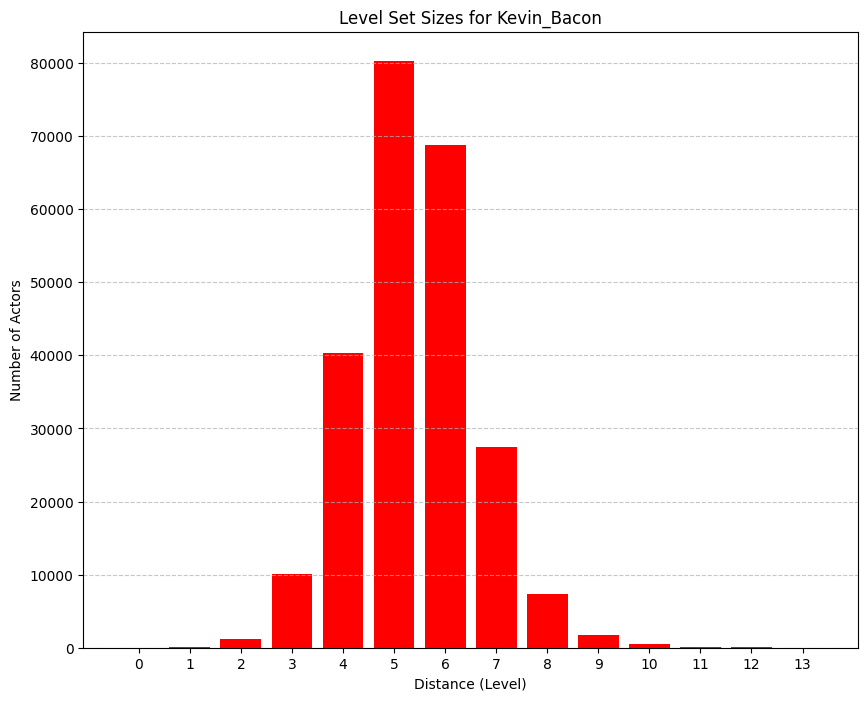



Level Set Graph for Small actor graph


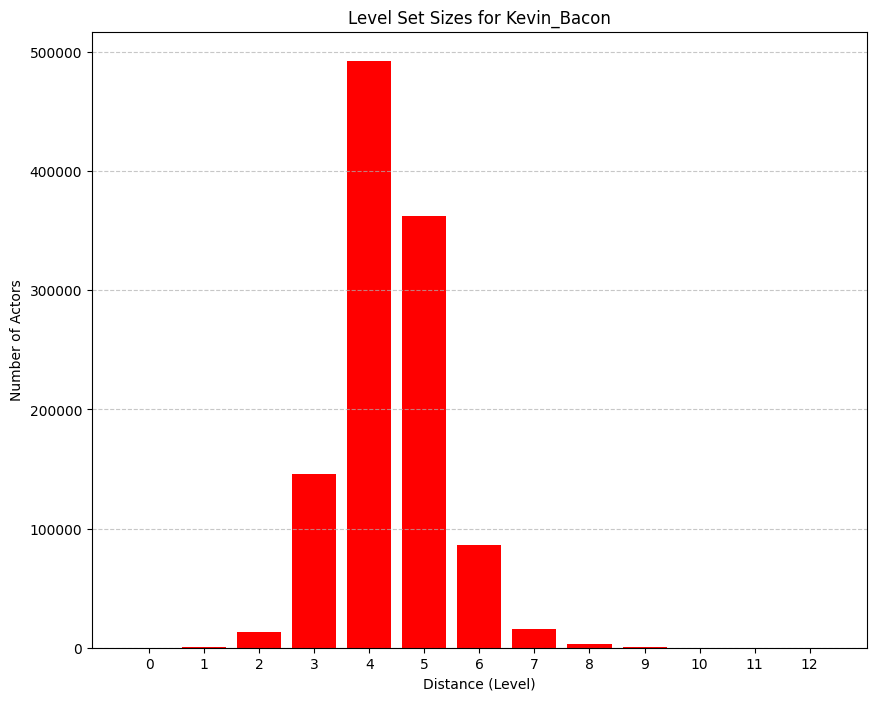

In [20]:
input_parameters = open("more-input.txt", 'r', encoding='utf-8') 
start_actor = 'Kevin_Bacon'
small_level_sets = compute_level_sets(small_actor_graph, start_actor)
print(f"Level Set Graph for Small actor graph")
plot_level_set(small_level_sets, start_actor)
print("\n")
large_level_sets = compute_level_sets(large_actor_graph, start_actor)
print(f"Level Set Graph for Large actor graph")
plot_level_set(large_level_sets, start_actor)




5. **Connected Components**: Determine the sizes of the connected components in each graph.


In [ ]:


print(f"Small Graph : {small_actor_graph.Size()}")
print(f"Large Graph : {large_actor_graph.Size()}")


6. **Edge Count Comparison**: Compare the number of edges traversed between vanilla BFS and Bidirectional BFS (Bi-BFS) for the pairs in the example input files. Include your own generated examples in this comparison.



7. **Wall-Clock Time**: Measure and compare the actual running times of BFS and Bi-BFS using the `timeit` module in Python. Provide wall-clock time data for the pairs in the example input files, as well as your own examples.


In [ ]:
def compare_algorithm_time(start, end, graph):
	bfs_time = timeit(lambda : bfs(start=start, end=end, graph=graph, merged=False), number=10)
	bi_bfs_time = timeit(lambda : BiDi_BFS(start=start, end=end, graph=graph, merged=False), number=10)
	return bfs_time, bi_bfs_time

def collect_runtime_data(input_parameters:str, graph:graph):
	bfs_times = []
	bi_bfs_times = []
	pairs = []
	for param in input_parameters:
		striped_param = param.strip().split()
		start, end = striped_param[0], striped_param[1]
		bfs_time, bi_bfs_time = compare_algorithm_time(start, end, graph)

		bfs_times.append(bfs_time)
		bi_bfs_times.append(bi_bfs_time)
		pairs.append(f"{start}->{end}")

	return bfs_times, bi_bfs_times, pairs

def plot_runtime_comparison(bfs_times, bi_bfs_times, pairs, graph_name):
    plt.figure(figsize=(12, 6))
    x = range(len(pairs))

    bar_width = 0.4  # Width of the bars
    plt.bar([i - bar_width / 2 for i in x], bfs_times, bar_width, label="BFS", color='skyblue')
    plt.bar([i + bar_width / 2 for i in x], bi_bfs_times, bar_width, label="Bi-BFS", color='salmon')

    plt.xticks(x, pairs, rotation=45, ha="right")
    plt.xlabel("Actor Pairs")
    plt.ylabel("Runtime (seconds)")
    plt.title(f"Runtime Comparison of BFS vs Bi-BFS ({graph_name})")
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
print("Runtime Comparison using Small Actor Graph")
input_parameters = open("more-input.txt", 'r', encoding='utf-8')  
bfs_times_small, bi_bfs_times_small, pairs_small = collect_runtime_data(input_parameters, small_actor_graph)
plot_runtime_comparison(bfs_times_small, bi_bfs_times_small, pairs_small, "Small Actor Graph")
input_parameters.close()

In [ ]:
print("Runtime Comparison using Large Actor Graph")
input_parameters = open("more-input.txt", 'r', encoding='utf-8')  
bfs_times_large, bi_bfs_times_large, pairs_large = collect_runtime_data(input_parameters, large_actor_graph)
plot_runtime_comparison(bfs_times_large, bi_bfs_times_large, pairs_large, "Large Actor Graph")
input_parameters.close()